In [105]:
# import the Package 

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import time
import copy
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import warnings
import stumpy
import random

from scipy.signal import find_peaks
from pyod.models.knn import KNN as pyodKNN
from statistics import median
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from statsmodels.tsa.seasonal import STL


In [106]:
# This is the data batching function
def data_batching(time_series, period):
    print("Batching Data")
    batch = []
    for i in range(len(time_series) - period):
        batch.append(time_series[i: i+period])
    result = np.stack(batch)
    print("End of Batching")
    return result

In [107]:
# This is the deep neural network autoencoder achitecture
# with 3 encoder layer and 3 decoder 
class Deep_Neural_network_autoencoder(nn.Module):
    def __init__(self, input_n,  device):
        super(Deep_Neural_network_autoencoder, self).__init__()
        self.stack = torch.nn.Sequential(
            torch.nn.Linear(input_n, 512, bias=True), 
            torch.nn.ReLU(),                                
            torch.nn.Dropout(0.2, inplace=False),
            torch.nn.Linear(512 , 256 , bias=True),
            torch.nn.ReLU(),                                
            torch.nn.Dropout(0.2, inplace=False),
            torch.nn.Linear(256 , 64, bias=True),
            torch.nn.ReLU(),            
            torch.nn.Dropout(0.2, inplace=False),
            torch.nn.Linear(64 , 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2, inplace=False),
            torch.nn.Linear(256 , 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2, inplace=False),
            torch.nn.Linear(512 , input_n, bias=True)
        ).to(device)

    def forward(self, x):
        x = self.stack(x)
        return x

In [108]:
# Actual MLP AE model
def deep_neural_network_autoencoder(test_X, train_X, learning_rate, iter):
#     device = torch.device('cpu')
    device = torch.device('cuda')
    
    # Clear some space from CUDA
    torch.cuda.max_split_size_mb = 10240
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.reset_max_memory_cached()
    loss = torch.nn.MSELoss()

    # Load Train data
    train_X = torch.from_numpy(train_X).type(torch.FloatTensor).cuda()
    
    model = Deep_Neural_network_autoencoder(len(train_X[0]), device)
    
    # Failed to implement CNN AE
#     model = CNN_autoencoder(len(train_X.detach().numpy()[1]), device)

    # Optimal function
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
    training_loss = []
    training_RMSE = []
    
    # Epoch to train
    for iter_num in range(iter):
#         print('Iteration:', iter_num)
        cnt = 0 
        rmse = []
        cnt +=1 
        # train and update weight
        model.train()
        train_y_pred = model(train_X)
        loss_train_val = loss(train_y_pred, train_X)
        training_loss.append(loss_train_val.item())
#         print(loss_train_val.item())

        opt.zero_grad()
        loss_train_val.backward()
        opt.step()
        
        training_RMSE.append(mean_squared_error(train_X.data.cpu().numpy(), train_y_pred.data.cpu().numpy(), squared = False))
    
    torch.cuda.empty_cache()
    index = range(len(training_loss))
    result = []
    
    # Clear some space to prevent memory overflow
    del train_X
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.reset_max_memory_cached()
    
    # If the dataset set is large predict part by part and free the space right after prediction
    if len(test_X) > 100000:
        for i in range(len(test_X) // 100000):
            temp = torch.from_numpy(test_X[i:i+100000]).type(torch.FloatTensor).cuda()
            test_y_pred = model(temp)
            result += list(test_y_pred.data.cpu().numpy())
            del temp
            torch.cuda.reset_max_memory_cached()
        temp = torch.from_numpy(test_X[len(test_X) % 100000 :]).type(torch.FloatTensor).cuda()
        test_y_pred = model(temp)
        result += list(test_y_pred.data.cpu().numpy())
        del temp
        torch.cuda.reset_max_memory_cached()
    else:
        test_X = torch.from_numpy(test_X).type(torch.FloatTensor).cuda()
        test_y_pred = model(test_X)
        result += list(test_y_pred.data.cpu().numpy())

    # Print the traning loss
    plt.title('Training loss')
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.plot(index, training_loss, color ="black")
    plt.show()
    print("Final training loss: ", training_loss[-1])

    return result

In [109]:
# Calculate the eulidean distance to two series
def Eulidean_Distance(x, y):
    x = np.array(x)
    y = np.array(y)
    return sum((x - y)**2)**0.5

In [110]:
# Get all TXT file 1 - 250 
def get_data_list():
    data_list = glob.glob('*.txt')
    return data_list

In [111]:
# Data preprocessing
def Data_preprocessing(df, split_n, window):
    
    print("Data preprocessing")
    
    df_test = df.iloc[split_n:,:].copy()
    df_train = df.iloc[:split_n, :].copy()

    scaler = MinMaxScaler(feature_range= (0,2))
    scaler2 = StandardScaler()
    
    df_train['y_scaled'] = scaler.fit_transform(df_train['y'].values.reshape(-1,1))
    df_test['y_scaled'] = scaler.transform(df_test['y'].values.reshape(-1,1))  
    
    df_train['y_s_scaled'] = scaler2.fit_transform(df_train['y'].values.reshape(-1,1))
    df_test['y_s_scaled'] = scaler2.transform(df_test['y'].values.reshape(-1,1))  
    
    df_train['diff'] = df_train['y'] - df_train['y'].shift(1)
    df_train['diff_scaled'] = scaler.fit_transform(df_train['diff'].values.reshape(-1,1))
    df_train['diff_s_scaled'] = scaler2.fit_transform(df_train['diff'].values.reshape(-1,1))
    
    df_test['diff'] = df_test['y'] - df_test['y'].shift(1)
    df_test['diff_scaled'] = scaler.transform(df_test['diff'].values.reshape(-1,1))
    df_test['diff_s_scaled'] = scaler2.transform(df_test['diff'].values.reshape(-1,1))
    
    df_train['acc'] = df_train['diff'] - df_train['diff'].shift(1)
    df_train['acc_scaled'] = scaler.fit_transform(df_train['diff'].values.reshape(-1,1))
    df_train['acc_s_scaled'] = scaler2.fit_transform(df_train['diff'].values.reshape(-1,1))
    
    df_test['acc'] = df_test['diff'] - df_test['diff'].shift(1)
    df_test['acc_scaled'] = scaler.transform(df_test['diff'].values.reshape(-1,1))
    df_test['acc_s_scaled'] = scaler2.transform(df_test['diff'].values.reshape(-1,1))
    
    df_train['MA'] = df_train['y'].rolling(window).mean()
    df_train['MA_scaled'] = scaler.fit_transform(df_train['MA'].values.reshape(-1,1))
    df_train['MA_s_scaled'] = scaler2.fit_transform(df_train['MA'].values.reshape(-1,1))
    
    df_test['MA'] = df_test['y'].rolling(window).mean()
    df_test['MA_scaled'] = scaler.transform(df_test['MA'].values.reshape(-1,1))
    df_test['MA_s_scaled'] = scaler2.transform(df_test['MA'].values.reshape(-1,1))
    
    df_train['Max'] = df_train['y'].rolling(window).max()
    df_train['Max_scaled'] = scaler.fit_transform(df_train['Max'].values.reshape(-1,1))
    df_train['Max_s_scaled'] = scaler2.fit_transform(df_train['Max'].values.reshape(-1,1))
    
    df_test['Max'] = df_test['y'].rolling(window).max()
    df_test['Max_scaled'] = scaler.transform(df_test['Max'].values.reshape(-1,1))
    df_test['Max_s_scaled'] = scaler2.transform(df_test['Max'].values.reshape(-1,1))    
    
    df_train['Min'] = df_train['y'].rolling(window).min()
    df_train['Min_scaled'] = scaler.fit_transform(df_train['Min'].values.reshape(-1,1))
    df_train['Min_s_scaled'] = scaler2.fit_transform(df_train['Min'].values.reshape(-1,1))
    
    df_test['Min'] = df_test['y'].rolling(window).min()
    df_test['Min_scaled'] = scaler.transform(df_test['Min'].values.reshape(-1,1))
    df_test['Min_s_scaled'] = scaler2.transform(df_test['Min'].values.reshape(-1,1))
    
    df_train['Std'] = df_train['y'].rolling(window).std()
    df_train['Std_scaled'] = scaler.fit_transform(df_train['Std'].values.reshape(-1,1))
    df_train['Std_s_scaled'] = scaler2.fit_transform(df_train['Std'].values.reshape(-1,1))
    
    df_test['Std'] = df_test['y'].rolling(window).std()
    df_test['Std_scaled'] = scaler.transform(df_test['Std'].values.reshape(-1,1))
    df_test['Std_s_scaled'] = scaler2.transform(df_test['Std'].values.reshape(-1,1))
  
    df_train['Range'] = df_train['y'].rolling(window).max() - df_train['y'].rolling(window).min()
    df_train['Range_scaled'] = scaler.fit_transform(df_train['Range'].values.reshape(-1,1))
    df_train['Range_s_scaled'] = scaler2.fit_transform(df_train['Range'].values.reshape(-1,1))
    
    df_test['Range'] = df_test['y'].rolling(window).max() - df_test['y'].rolling(window).min()
    df_test['Range_scaled'] = scaler.transform(df_test['Range'].values.reshape(-1,1))
    df_test['Range_s_scaled'] = scaler2.transform(df_test['Range'].values.reshape(-1,1))

    df_train = df_train.dropna().reset_index(drop=True)
    df_test = df_test.dropna().reset_index(drop=True)
    print('End of preprocessing')
    return df_train, df_test

In [112]:
# Matrix profile model
def matrix_profile(df_train, df_test, window, cand, norm):
    print("Calculating Matrix Profile")
    # Calcualte MP
    mp = stumpy.gpu_stump(df_test, window, df_train, ignore_trivial=False, normalize =norm)
    
    # Find the threshold
    threshold = sorted(mp[:, 0])[-1]*0.7
    
    # Count how many data above the thresdhold
    cnt = min(len(mp[mp[:,0] > threshold]), cand)
    
    # find and output the anomaly candidates
    anomaly_cand = np.argsort(mp[:, 0])[-cnt:-1]
    return list(anomaly_cand)

In [113]:
# Evaluate the predicted series and the original series for the AE
def ae_evaluate(pred, label, cand):
    print("Evaluating Autoencoder Results")

    rmse_list = []
    # Find the RMSE for each data 
    for i in range(len(label)):
        rmse = mean_squared_error(label[i], pred[i], squared=False)
        rmse_list.append(rmse)

    anomaly = []
    
    # Find the threshold
    theshold = sorted(rmse_list)[-1]*0.7
    
    # Count how many data above the thrshold
    cnt = 0 
    for i in rmse_list:
        if i > theshold:
            cnt+=1
            
    # select the anomaly candidates from the shortlisted index
    anomaly_cand_value = sorted(rmse_list)[-min(cnt, 20):]
    anomaly_cand = [rmse_list.index(i) for i in anomaly_cand_value]
    
    # Output
    return anomaly_cand

In [114]:
# From the distribution
# Select the top n condense bins
# Then select their mean index as the output index
def get_top_n_anomaly(hist_v, bin_edges, total_anomaly_cand, n, window):
    print("Get the top n anomaly based on the binned group")
    
    # Sort the data for finding index
    hist_v = list(hist_v)
    hist_v_sorted = sorted(hist_v)
    bin_edges = list(bin_edges)
    
    result = []
    # Loop to find n largest bin
    for i in range(n):
        
        # Find the n th largest bin
        max_bin = random.choice(find(hist_v,hist_v_sorted[-(i+1)] ))
        
        # Find the bin range lower and upper
        max_range_low = bin_edges[max_bin]
        max_range_high = bin_edges[max_bin + 1]
        
        # mark the bin so next time wont select the same bin.
        hist_v[max_bin] = -1
        
        # Find out all anomaly candidates that within the lower and upper bin range
        anomaly_list = list(filter(lambda x: (x >= max_range_low) & (x <= max_range_high), total_anomaly_cand))
        
        # Tried different methods for the anomaly
        
        # Find out the mean index 
        anomaly = sum(anomaly_list) // len(anomaly_list)
        
#         anomaly = min(anomaly_list)
#         anomaly = max(set(anomaly_list), key=anomaly_list.count)
#         anomaly = (max_range_low + max_range_high) // 2
#         anomaly = statistic.median(anomaly_list)
#         anomaly = int(max_range_high)
        
        # append the anomaly index into the output
        result.append(anomaly)
    
    # if we are finding 1 anoamly form the largest bin
    # we need to ensure we are finding the most condense bar within that selected candiates. 
    # so this is used to find out the real output anoamly index 
    if ((max_range_high - max_range_high) > window) & (n == 1): 
        
        # Generate other distribution with the selected anoamly list
        hist_v2, bin_edges_v2 = np.histogram(anomaly_list)
        
        # Find the largest bin 
        max_bin = hist_v2.index(max(hist_v2))
        
        # Find the lower and upper bin size
        max_range_low = bin_edges_v2[max_bin]
        max_range_high = bin_edges_v2[max_bin + 1]
        
        # Select the anomaly within the bin range
        anomaly_list = list(filter(lambda x: (x >= max_range_low) & (x <= max_range_high), anomaly_list))

        # Find the real anoamly index and append it into the result
        anomaly = sum(anomaly_list) // len(anomaly_list)    
        result.append(anomaly)
        
    # output the result
    return result

In [115]:
# Compare the list of shortlisted anomaly to the training set
def compare_with_train(idx, df_test, df_train, window, bin_width):
    print('Comparing target anomaly period with training dataset')
    sum_dis = []
    scaler = StandardScaler()  
    
    # using standard scaler to scale the data, so we are finding the z-score distance
    y = np.array(scaler.fit_transform(df_train['y'].values.reshape(-1,1)))
    x = np.array(scaler.transform(df_test['y'][int(idx-bin_width):int(idx+bin_width)].values.reshape(-1,1)))
    
    # compare the anomaly series to each series at the training set 
    for i in range(len(y) - int(2 * bin_width)):
        
        # sub time series from training set 
        target = y[i : i+int(2 * bin_width)]
        
        # append the distance for calculation
        sum_dis.append(Eulidean_Distance(x, target))

    # Failed apporach finding the distance
#     idx = sum_dis.index(min(sum_dis))
#     z_score = stats.zscore(sum_dis)
#     return z_score[idx]
#     sum_sort = sorted(sum_dis)
#     split = int(len(sum_dis) * 0.001)
#     split = 20
#     dis = sum(sum_sort[-split:]) / split 
#     return sum_sort[0][0]

    # output the mean distance
    # The true anomaly should have the smallest distance 
    return sum(sum_dis) / len(sum_dis)

In [116]:
# KNN apporach
def KNN(df_train, df_test, cand, window):
    print("Constructing the KNN model.")
    
    # KNN model
    knn = pyodKNN(contamination= 0.00000000000001 )
    anomaly_cand = []
    
    print('Fiting KNN')
    # Train KNN
    knn.fit(df_train)
    print('Finished fitting')
    
    print('Predicting with KNN')
    
    # Predict the anomaly from the trained KNN
    result = knn.predict(df_test)
    
    # Select the anoamly index 
    df = pd.DataFrame({'label':result})
    df = df.reset_index()
    df = df[df['label'] == 1]
    anomaly_list = df.index.values.tolist()
    
    # Calculate the distribution of the anomaly
    hist_v,bin_edges = np.histogram(anomaly_list, bins=50,  density = False)
    
    # find out how many bin have more than 0 elements.
    cand_max = len(list(filter(lambda x: x > 0 , hist_v)))
    
    # Plot the KNN results
    plt.title('Final anomaly candidates distribution from all models.')
    plt.hist(anomaly_list, bins = bin_edges)
    plt.show()
    
    # If there is anomaly, select one from each bin, and output the selected anomaly 
    if cand_max > 0:
        anomaly_cand = get_top_n_anomaly(hist_v, bin_edges, anomaly_list, min(cand, cand_max), window)
        print('Anomaly found from KNN',anomaly_cand)

    return anomaly_cand

In [117]:
# Find all the index with the given value in the list, no python builtin lib for this
# this function is used to support KNN model get the result 
# But finally KNN is not used, so this is also not used. 
def find(arr, y):
    print('Finding all indexes with the given value in the list')
    result = []
    for i, x in enumerate(arr):
        if x == y:
            result.append(i)
    return result

In [118]:
# Fidn the period of the series 
def find_period(series):
    print('Finding the period of the time series.')
    
    # Use middle 50% of the series for finding the period, exclude the outlier.
    series = series[int(len(series)*0.25):int(len(series)*0.75)] 
    
    # Find all the local noise peaks and real peaks 
    peak, properties = find_peaks(series, prominence= 0.000001)
    
    # Plot the distribution into 20 bins
    hist_v1,bin_edges1 = np.histogram(properties['prominences'], bins=20, density = False)
    
    # Plot the series and the peaks 
    peak = list(peak)
    plt.title('Prominences score distribution for all peaks.')
    plt.xlabel('Prominences score')
    plt.ylabel('Count')
    plt.hist(properties['prominences'], bins = bin_edges1)
    plt.show()
    
    plt.figure(figsize=[30,4])
    plt.title('Peaks at the training dataset.')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.plot(series)
    temp = [ series[i] for i in peak] 
    plt.plot(peak, temp, "x")
    plt.show()
    
    # Find out the prominence threshoold based on the peaks that have high prominence. 
    max_range_low = bin_edges1[5]
    max_range_high = bin_edges1[-1]
    threshold = list(filter(lambda x: (x >= max_range_low) & (x <= max_range_high), properties['prominences']))    
    threshold = (sum(threshold) / len(threshold))*0.7
    
    print('The selected prominences score: ', threshold)
    
    # find the peak again but this time have the prominence theshold. 
    peak, properties = find_peaks(series, prominence=threshold)    
    
    # Plot the final peaks found. 
    plt.figure(figsize=[30,4])
    plt.title('Fianl peaks found at the training dataset.')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.plot(series)
    temp = [ series[i] for i in peak] 
    plt.plot(peak, temp, "x")
    plt.show()
    
    # Calculate the peak to peak distance 
    temp = pd.DataFrame({'peak':list(peak)})
    temp['peak_diff'] = temp['peak'] - temp['peak'].shift(1)
    temp = temp.dropna() 
    
    
    # Average all the peak to peak distance to find the true period of the series 
    period = sum(temp['peak_diff'].values.tolist()) // temp.shape[0]
    print('The period of the given time series is :',period)
    return period

In [127]:
# Aggregate all the result, then output it as a single file
def generate_output_result():
    csv_list = glob.glob('*.csv')
    num_list = []
    anomaly_list = []
    data_list = []
    for path in csv_list:
        if 'result' not in path:
            continue
        temp = pd.read_csv(path)
        anomaly_list.append(int(temp['anomaly'].values.tolist()[0]))
    result = pd.DataFrame({'anomaly':anomaly_list})
    result = result.reset_index()
    result['index'] = result['index']+1
    result.columns = ['No.', 'Location of Anomaly']
    print('Final submision result:')
    print(result)
    result.to_csv('submission.csv', index =False)
    print('Result saved to submission.csv')

In [120]:
# If the series is too large, subsameple it to 50% size
# only select the odd index as the new series
def subsampling(series):
    print('Sub sampling series for too large data. Length of data:', len(series))
    sub_sample = list(range(1, len(series),2 ))
    return series[sub_sample]

In [121]:
# Plot the grapg function so i no need to copy everytime 
def plot_graph(size, title, index, content):
    plt.figure(figsize=size)
    plt.title(title)
    plt.plot(index, content)
    plt.show()    

Currently working on dataset: 001_UCR_Anomaly_35000.txt
The dataset length: 79795


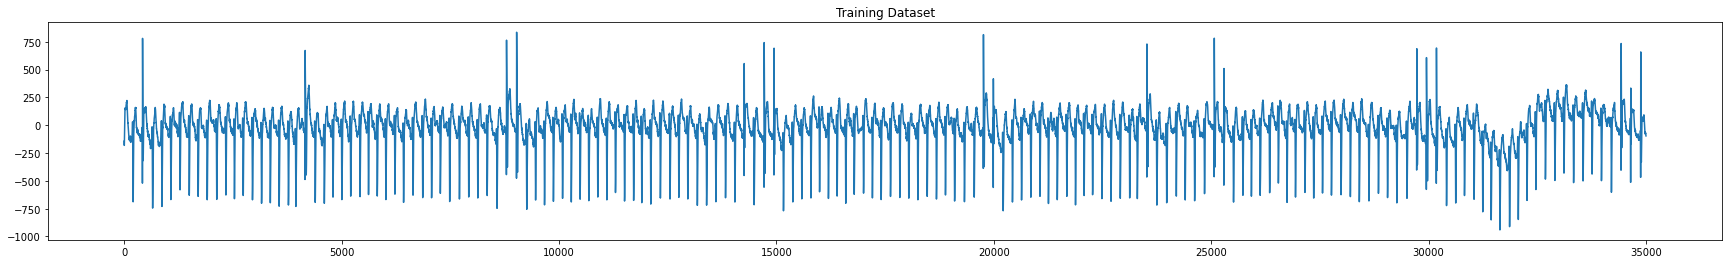

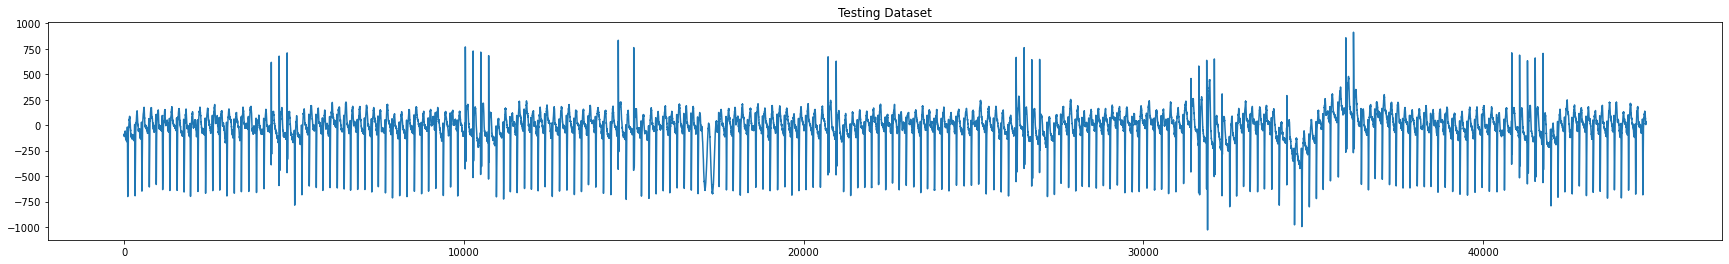

Finding the period of the time series.


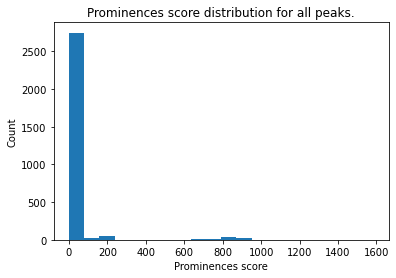

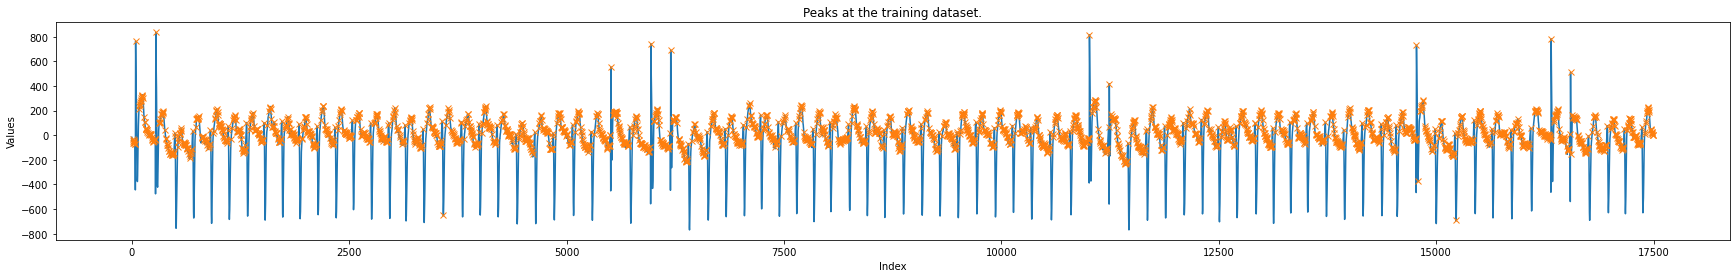

The selected prominences score:  600.3156722344445


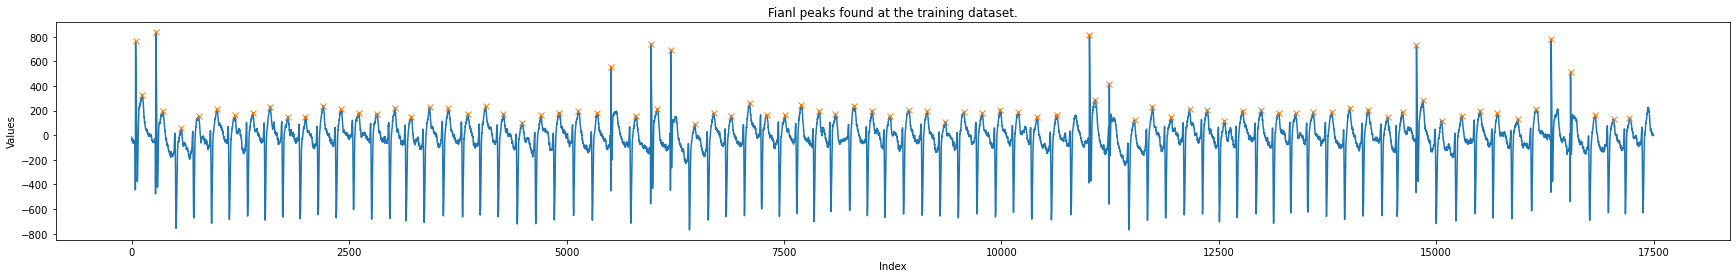

The period of the given time series is : 202.0


KeyboardInterrupt: 

In [122]:
# Main Function 


# Window size is the most important features. 
# cannot use list to loop, as wrong window size will increase the error significantly
# Cannot use one size fit all as different time series have different window sizes
# window = 150


# # of max anomaly candidates reported from each model
cand = 20

# Select the top n anomaly group
n = 1

# Get the dataset list
process_data_list = get_data_list()

# Loop the dataset
for path in process_data_list:

    # Load the data
    file = np.loadtxt(path)
    
    # print the data 
    print('Currently working on dataset:',path)
    df = pd.DataFrame({'y':file})

    # get the split and dataset number 
    split_n = int(path.split('_')[-1].split('.')[0])
    split_n_sub = split_n
    dataset_num = path.split('_')[0]
    print('The dataset length:',len(file))
    
    # Plot the time series
    plot_graph([30,4], 'Training Dataset', range(split_n), df['y'].values.tolist()[:split_n])
    plot_graph([30,4], 'Testing Dataset', range(df.shape[0]-split_n),df['y'].values.tolist()[split_n:])

    # Find the period with the training set
    period = find_period(file[:split_n])
    
    # Set the window as the period
    window = int(period * 1)
    
    # Decompose the series
    stl = STL(file, period = int(period), robust = False ).fit()
    
    # plot the result
    stl.plot()
    
    # Print the STL results
    plot_graph([30,4], 'Training Dataset Seasonal + Noise', range(split_n), stl.seasonal[:split_n] + stl.resid[:split_n])
    plot_graph([30,4], 'Testing Dataset Seasonal + Noise', range(df.shape[0]-split_n),stl.seasonal[split_n:] + stl.resid[split_n:])
    plot_graph([30,4], 'Testing Dataset Trend', range(df.shape[0]-split_n), stl.trend[split_n:])
    plot_graph([30,4], 'Testing Dataset Seasonal', range(df.shape[0]-split_n),stl.seasonal[split_n:])
    plot_graph([30,4], 'Testing Dataset  Noise', range(df.shape[0]-split_n), stl.resid[split_n:])
    
    # Use the seasonal with noise replace the original series as this have no trend 
    # Easier to find anomaly
    file = stl.seasonal + stl.resid

    df = pd.DataFrame({'y':file})
    
    # If the series is too large, sub smaple it
    if df.shape[0] > 700000:
        df = pd.DataFrame({'y':subsampling(file)})
        split_n_sub = split_n // 2
    
    # Data preprocessing
    df_train, df_test = Data_preprocessing(df, split_n_sub, window)
    

# We have tried to analysis and predict the data based on different attributes.
#     evaluate_list = ['MA', 'diff', 'Max', 'Min','Std', 'Range', 'y']
#     evaluate_list = ['diff', 'Max', 'Min', 'y', 'y_s']

    # Finally we decided to use following metrics for the anomaly detection
    evaluate_list = ['diff', 'Max', 'Min', 'y', 'acc']
    

    total_anomaly_cand = []

    # find anomaly with each selected attributes
    for i in evaluate_list:
        
        # Prepare training and testing set for different model
        # Then train and predict with the given data

#       Create matrix profile model, train and predict and output anoamlay candidates     
        mp_train = df_train[i].values.tolist()
        mp_test = df_test[i].values.tolist()
        mp_cand = matrix_profile(mp_train, mp_test, window, cand, True)
        print('Using Attributes', i, 'Matrix Profile return selected anomaly:', mp_cand)
        total_anomaly_cand += mp_cand

#       Create autoencoder model, train and predict and output anoamlay candidates  
        ae_train = data_batching(df_train[i+'_scaled'].values.tolist(), window)
        ae_test = data_batching(df_test[i+'_scaled'].values.tolist(), window)
        result = deep_neural_network_autoencoder(ae_test, ae_train, 0.005,250)
        result = ae_evaluate(result, ae_test, cand)
        print('Using Minmax Sclaler Attributes', i, 'Auto Encoder return selected anomaly:', result)
        total_anomaly_cand += result
     
        # Standard Scaling data is not used as the performs is not good
#         ae_train_s = data_batching(df_train[i+'_s_scaled'].values.tolist(), window)
#         ae_test_s = data_batching(df_test[i+'_s_scaled'].values.tolist(), window)
#         result = deep_neural_network_autoencoder(ae_test_s, ae_train_s, 0.005,250)
#         result = ae_evaluate(result, ae_test, cand)
#         print('Using Standard Scaler Attributes', i, 'Auto Encoder return selected anomaly:', result)
#         total_anomaly_cand += result

        # KNN is not used as the training time is too long
#         knn_train = data_batching(df_train[i].values.tolist(), window )
#         knn_test = data_batching(df_test[i].values.tolist(), window )
#         result = KNN(knn_train, knn_test, cand, window)
#         total_anomaly_cand += result

    # Print out the number of anoamly candidates found by the models
    print('There are toally',len(total_anomaly_cand), 'anomaly candidates reported from all models.')
    
    # The bin size / the number of bins is critical, it will directly affect the anomaly we choose
    # Tried differnet apporach to make the result single or only 1 output
    #     hist_v,bin_edges = np.histogram(total_anomaly_cand, bins= max(total_anomaly_cand) - min(total_anomaly_cand) // window, density = False)
    #     hist_v,bin_edges = np.histogram(total_anomaly_cand, bins=75 , density = False)
    # Finally we select the following method to find the distribution
    hist_v,bin_edges = np.histogram(total_anomaly_cand, bins= min((max(total_anomaly_cand) - min(total_anomaly_cand)) // window, 30), density = False)
    
    
    # Print out the anomaly candidates distribution
    plt.title('Final anomaly candidates distribution from all models.')
    plt.hist(total_anomaly_cand, bins = bin_edges)
    plt.show()
    
    # Find out the top n anomaly candidates from the distribution constructed above
    top_n_anomaly = get_top_n_anomaly(hist_v, bin_edges, total_anomaly_cand, n, window)
    
    # Find out the bin width
    bin_width = bin_edges[1] - bin_edges[0]
    
    # If there are multiple anomaly shortlisted candidates, compare them with all traning set one by one
    if n != 1:
        temp = []
        # Loop all candidates
        for i in range(n):
            
            # Calculate the mean distance the anomaly series to the whole training set 
            dis = compare_with_train(top_n_anomaly[i], df_test, df_train, window,bin_width )
            temp.append(dis)
            
        # Print the results 
        print('top n anomaly', top_n_anomaly)
        print('min distance at train', temp)
        
        # Finally selec the anoamly with maximum distnce indicate the series is most far from training set
        anomaly_idx = temp.index(max(temp))
    else:
        anomaly_idx = 0 # if only 1 candidate no need to compare just select the first one
        
    # Calculate the final anomaly index
    anomaly = top_n_anomaly[anomaly_idx] + split_n_sub + window
    
    # Multiply index by 2 if the data was subsampled
    if split_n != split_n_sub:
        anomaly *= 2 
    
    # Save the result
    print('Saving result')
    output = pd.DataFrame({'dataset':path, 'anomaly':anomaly}, index = [0])
    output.to_csv(dataset_num + '_result' + '.csv')
    print(dataset_num,'result saved')
    print('Anomaly Idx:',anomaly)
    print('Anomaly idx at test:', anomaly - split_n )
    print('Train test split idx:', split_n )
    
# Aggregate all result and form a submission file
generate_output_result()


In [128]:
generate_output_result()

Final submision result:
     No.  Location of Anomaly
0      1                52179
1      2                56672
2      3                46560
3      4                 5530
4      5                 5354
..   ...                  ...
245  246               210856
246  247               106414
247  248                 2078
248  249                 6304
249  250                 7348

[250 rows x 2 columns]
Result saved to submission.csv
